***

<center><u><H1>Classificazione: k-Nearest Neighbour</H1></u></center>

***

Nella classificazione, l'obiettivo è quello di categorizzare, o classificare, le osservazioni sconosciute in un insieme discreto e finito di categorie, o classi. Viene quindi appresa la relazione tra una **variabile dipendente di tipo categorico** e **una o più variabili indipendenti**.

Quando la variabile dipendente può assumere due soli valori, si parla di classificazione binaria, altrimenti si parla di classificazione multi-classe (o multi-livello).

# 1 Dataset semplificato

## 1.1 Importazione

Prima di tutto importiamo i moduli necessari:

In [117]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

sns.set_style("whitegrid")
sns.set_palette("pastel")

La funzione definita qui di seguito è ispirata a quella dispoibile a [questo link](http://www.cse.chalmers.se/~richajo/dit866/backup_2019/lectures/l3/Plotting%20decision%20boundaries.html) e permette di creare un grafico con le regioni di decisione del classificatore:

In [118]:
def plot_decision_boundary(clf, input_x, input_y, cmap='Paired_r'):
    """
    Questa funzione fornisce il grafico delle regioni di decisione di un classificatore.
    :param clf: classificatore allenato
    :param input_x: variabili indipendenti
    :param input_y: variabile dipendente
    :param cmap: schema dei colori
    :return: viene mostrato il grafico con le regioni di decisione
    """
    step = 0.02  # passo della griglia per le regioni di decisione
    x_min, x_max = input_x[:,0].min() - 10*step, input_x[:,0].max() + 10*step  # max/min asse x
    y_min, y_max = input_x[:,1].min() - 10*step, input_x[:,1].max() + 10*step  # max/min asse y
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))  # griglia di valori (x, y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  # predizioni su ogni punto della griglia
    Z = Z.reshape(xx.shape)  # rendiamo le dimensioni compatibili

    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(input_x[:,0], input_x[:,1], c=input_y, cmap=cmap, edgecolors='k')
    plt.show()

### 1.2 Caratteristiche del dataset

Come sempre, valutiamo le caratteristiche principali del dataset [social_network_ads](https://github.com/shivang98/Social-Network-ads-Boost/blob/master/Social_Network_Ads.csv) (la versione su VLE usata sotto è stata depurata delle feature 'Gender' e 'User ID'):

In [119]:
df = pd.read_csv("00_datasets/social_network_ads.csv")
print(df.head())

   Age  EstimatedSalary  Purchased
0   19            19000          0
1   35            20000          0
2   26            43000          0
3   27            57000          0
4   19            76000          0


In [120]:
print(df.dtypes)

Age                int64
EstimatedSalary    int64
Purchased          int64
dtype: object


In [121]:
print("Sono presenti {} osservazioni con {} feature.".format(df.shape[0], df.shape[1]-1))

Sono presenti 400 osservazioni con 2 feature.


In [122]:
df.describe()

Age  EstimatedSalary   Purchased
count  400.000000       400.000000  400.000000
mean    37.655000     69742.500000    0.357500
std     10.482877     34096.960282    0.479864
min     18.000000     15000.000000    0.000000
25%     29.750000     43000.000000    0.000000
50%     37.000000     70000.000000    0.000000
75%     46.000000     88000.000000    1.000000
max     60.000000    150000.000000    1.000000

Nella classificazione, può essere utile osservare come sono distribuite le categorie della variabile dipendente:

In [123]:
print(df.iloc[:,-1].value_counts())

Purchased
0    257
1    143
Name: count, dtype: int64


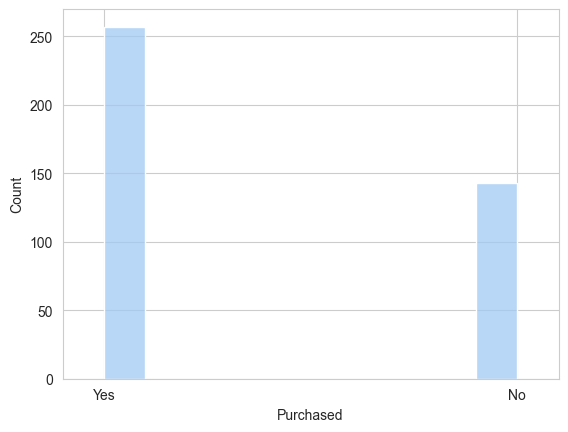

In [124]:
fig, ax = plt.subplots()
sns.histplot(data=df, x='Purchased')
ax.set_xticks([0, 1], labels=('Yes', 'No'))
ax.set_xlim([-0.1, 1.1])
plt.show()

Possiamo osservare come vi sia un certo sbilanciamento verso i "no", per cui quando osserveremo i risultati dovremo ricordarci di questo aspetto.

## 1.3 Data pre-processing

### 1.3.1 Dati mancanti

In [125]:
missing_data = df.isnull()

for col in missing_data.columns:
    count = sum(missing_data[col])
    if count > 0:
        print(f"{col}: {count/missing_data.shape[0]:.2%} ({count} su {missing_data.shape[0]}) mancanti.")

Perfetto, non ci sono dati mancanti.

### 1.3.2 Outliers

<Axes: ylabel='Age'>

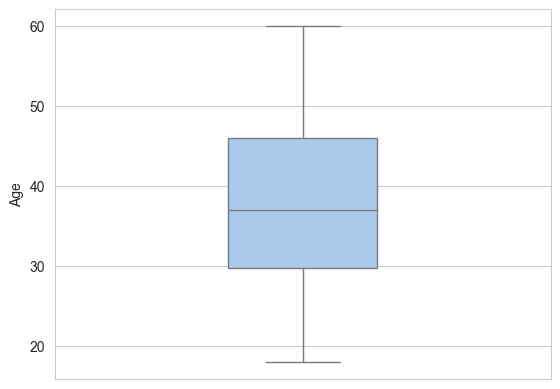

In [126]:
sns.boxplot(y="Age", data=df, width=0.3)

<Axes: ylabel='EstimatedSalary'>

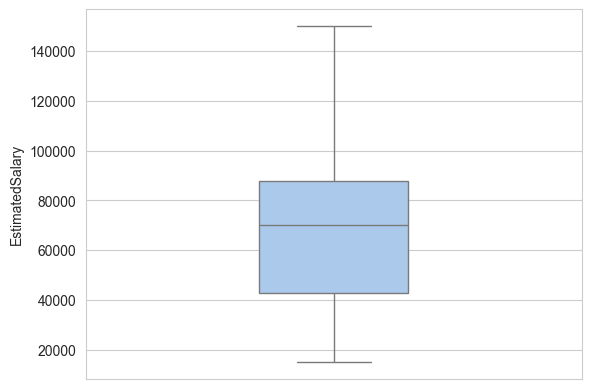

In [127]:
sns.boxplot(y="EstimatedSalary", data=df, width=0.3)

### 1.3.3 Trasformazione

Per lo scopo di questo esercizio, non abbiamo necessità di modificare le unità di misura. Inoltre, non abbiamo feature categoriche, per cui non c'è necessità di codificare le variabili.

## 1.4 Train/test split

Procediamo con il metodo holdout per semplicità. Anche qui convertiamo gli array in NumPy array per utilizzare le funzioni successive:

In [128]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 1.5 Feature scaling

In questo caso, dobbiamo implementare il feature scaling. Spesso, si ricorre alla standardizzazione e, a meno di casi particolari, faremo così nel corso. Procediamo come visto in questo ordine:
- creazione di un oggetto StandardScaler
- applicazione del metodo fit_transform() sul training set
- applicazione del metodo transform() (senza fit!) sul test set

In [129]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 1.6 KNN

Gli step precedenti rimangono del tutto invariati indipendentemente dall'algoritmo che andremo ad utilizzare. Ora ci concentriamo sul KNN, ma per gli altri che valuteremo la preparazione dei dati rimarrà invariata!

### 1.6.1 Allenamento e predizioni

Per applicare l'algoritmo KNN di classificazione, procediamo come segue:
- creazione di un oggetto [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) con gli iper-parametri desiderati
- chiamata del metodo fit() sul training set
- predizioni sul test set

In [130]:
# creazione oggetto KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', p = 2)

Definire la distanza di Minkowski con $p=2$ come metrica equivale al settaggio di default, ovvero la distanza Euclidea. E' comunque una buona idea esplicitarlo in questo modo tra gli argomenti in modo da rendere evidente nel codice cosa si sta effettivamente allenando.

In [131]:
# training
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [132]:
# predizioni
y_hat = classifier.predict(X_test)

### 1.6.2 Prestazioni

In [133]:
print("Train set Accuracy: ", accuracy_score(y_train, classifier.predict(X_train)))
print("Test set Accuracy: ", accuracy_score(y_test, y_hat))

Train set Accuracy:  0.921875
Test set Accuracy:  0.8875


Possiamo calcolare la Confusion Matrix tramite la funzione [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) e ricavare le metriche come visto:

In [134]:
cm = confusion_matrix(y_test, y_hat)
cm

array([[56,  2],
       [ 7, 15]])

In [135]:
cm_acc = np.trace(cm)/np.sum(cm)
cm_sens = np.diagonal(cm) / np.sum(cm, axis=1)
cm_prec = np.diagonal(cm) / np.sum(cm, axis=0)
f1_vec = (2 * cm_sens * cm_prec) / (cm_sens + cm_prec)

print("Accuracy: {}".format(cm_acc))
print("Sensitivity per class: {}".format(cm_sens))
print("Precision per class: {}".format(cm_prec))
print("F1 per class: {}".format(f1_vec))
print("-"*80)
print("F1 score: ", f1_score(y_test, y_hat, average='macro'))
print("F1 score: ", np.mean(f1_vec))

Accuracy: 0.8875
Sensitivity per class: [0.96551724 0.68181818]
Precision per class: [0.88888889 0.88235294]
F1 per class: [0.92561983 0.76923077]
--------------------------------------------------------------------------------
F1 score:  0.8474253019707565
F1 score:  0.8474253019707565


Un altro approccio può essere l'utilizzo della funzione [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html):

In [136]:
print(classification_report(y_test, y_hat, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        58
           1       0.88      0.68      0.77        22

    accuracy                           0.89        80
   macro avg       0.89      0.82      0.85        80
weighted avg       0.89      0.89      0.88        80



Possiamo visualizzare la Confusion Matrix con la funzione [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html):

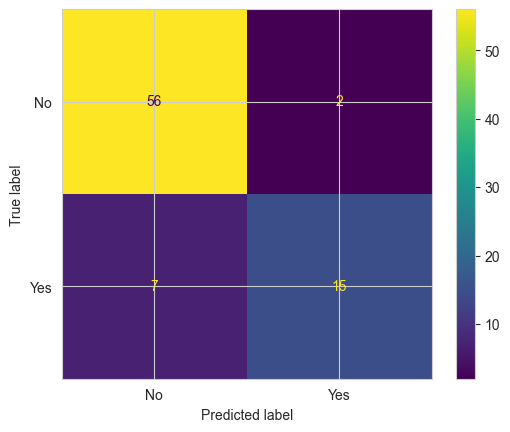

In [137]:
disp = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
disp.plot()

Se si vuole definire con un pochino più di flessibilità il grafico, può convenire ricorrere al metodo from_estimator():

In [138]:
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=['No', 'Yes'],
        cmap=plt.cm.Blues
)
plt.show()

### 1.6.3 Ottimizzazione di $k$

Il valore di $k$ e la metrica sono due esempi di [iper-parametri](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). In generale, essi rappresentano i parametri che ci permettono di controllare ed adattare il tipo di apprendimento dell'algoritmo; si differenziano dai parametri "tradizionali", i quali sono ottenuti tramite l'addestramento vero e proprio dell'algoritmo.

Proviamo a valutare se nel nostro algoritmo KNN ci sono dei valori di $k$ migliori:

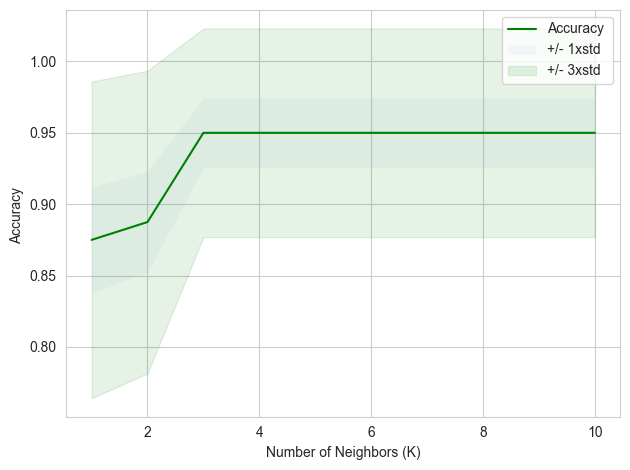

In [139]:
Ks = 11 # massimo valore di k
mean_acc = np.zeros((Ks-1)) # inizializzazione
std_acc = np.zeros((Ks-1)) # inizializzazione

for n in range(1,Ks): # iterazione per ogni k

    # Train Model and Predict
    classifier = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_hat = classifier.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, y_hat)
    std_acc[n-1]=np.std(y_hat==y_test)/np.sqrt(y_hat.shape[0])

# plot
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [140]:
Ks = 11 # massimo valore di k
f1 = np.zeros((Ks-1)) # inizializzazione

for n in range(1,Ks): # iterazione per ogni k

    # Train Model and Predict
    classifier = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_hat = classifier.predict(X_test)
    f1[n-1] = f1_score(y_test, y_hat, average='macro')

# plot
plt.plot(range(1,Ks),f1,'g')
plt.ylabel('F1 ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

Sembrerebbe che k=3 sia la soluzione migliore, per cui sfruttiamola!

In [141]:
classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)

classifier.fit(X_train, y_train)

y_hat = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_hat)
cm

array([[55,  3],
       [ 1, 21]])

In [142]:
cm_acc = np.trace(cm)/np.sum(cm)
cm_sens = np.diagonal(cm) / np.sum(cm, axis=1)
cm_prec = np.diagonal(cm) / np.sum(cm, axis=0)
f1_vec = (2 * cm_sens * cm_prec) / (cm_sens + cm_prec)
print("Accuracy: {}".format(cm_acc))
print("Sensitivity per class: {}".format(cm_sens))
print("Precision per class: {}".format(cm_prec))
print("F1 per class: {}".format(f1_vec))
print("F1 score: ", np.mean(f1_vec))

Accuracy: 0.95
Sensitivity per class: [0.94827586 0.95454545]
Precision per class: [0.98214286 0.875     ]
F1 per class: [0.96491228 0.91304348]
F1 score:  0.938977879481312


In [143]:
disp = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
disp.plot()

Per concludere, possiamo osservare le regioni di decisione:

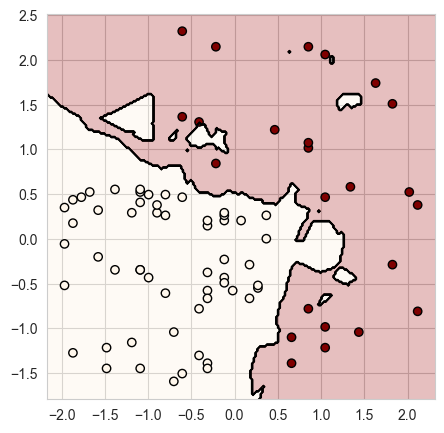

In [144]:
plot_decision_boundary(classifier, X_test, y_hat, cmap='OrRd')

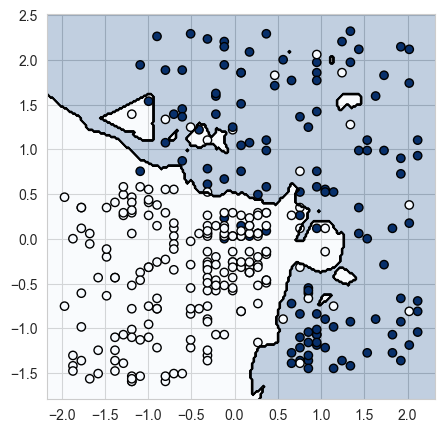

In [145]:
plot_decision_boundary(classifier, X_train, y_train, cmap='Blues')

***
# 2 Dataset avanzato

Ora che abbiamo compreso il funzionamento del KNN, procediamo con un altro esempio, prendendo un dataset più complesso. 

Il dataset titanic.csv, disponibile a [qeusto link](https://github.com/datasciencedojo/datasets/blob/master/titanic.csv), che contiene varie informazioni sui passeggeri del Titanic e, come DV, l'informazione relativa alla sopravvivenza. Le feature sono:
- **PassengerId**: ID del passeggero;
- **Survived**: sopravvivenza indicata come 1 (si) o 0 (no);
- **Pclass**: classe del biglietto (da 1 a 3);
- **Name**: nome del passeggero;
- **Sex**: genere del passeggero;
- **Age**: età del passeggero;
- **SibSp**: numero di fratelli/sorelle/sposi a bordo;
- **Parch**: numero di parenti (figli inclusi) a bordo;
- **Ticket**: numero del biglietto;
- **Fare**: prezzo del biglietto;
- **Cabin**: numero della cabina;
- **Embarked**: porto in cui si è imbarcato il passeggero (C = Cherbourg, Q = Queenstown, S = Southampton).

## 2.1 Caratteristiche del dataset

In [146]:
df = pd.read_csv("00_datasets/titanic.csv")
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [147]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Come data type, non notiamo niente di anomalo per come sono memorizzate le feature.

In [148]:
print("Sono presenti {} osservazioni con {} feature.".format(df.shape[0], df.shape[1]-1))

Sono presenti 891 osservazioni con 11 feature.


In [149]:
df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [150]:
df.describe(include='object').T

count unique                      top freq
Name       891    891  Braund, Mr. Owen Harris    1
Sex        891      2                     male  577
Ticket     891    681                   347082    7
Cabin      204    147                  B96 B98    4
Embarked   889      3                        S  644

Osservamo la distribuzione di sopravvissuti e non:

[Text(0, 0, 'No'), Text(1, 0, 'Si')]

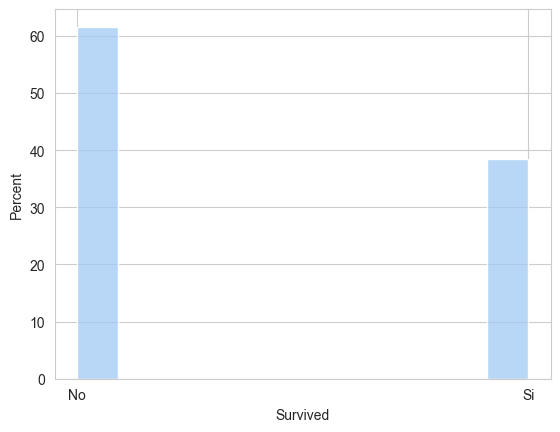

In [151]:
p = sns.histplot(df, x="Survived",stat="percent")
p.set_xticks([0, 1])
p.set_xticklabels(['No','Si'])

Solitamente, la DV viene inserita in fondo. Cambiamo quindi l'ordine delle colonne con un piccolo trucco sfruttando il metodo pop():

In [152]:
survived_col = df.pop("Survived")
df['Survived'] = survived_col
df

PassengerId  Pclass                                                 Name  \
0              1       3                              Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)   
2              3       3                               Heikkinen, Miss. Laina   
3              4       1         Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                             Allen, Mr. William Henry   
..           ...     ...                                                  ...   
886          887       2                                Montvila, Rev. Juozas   
887          888       1                         Graham, Miss. Margaret Edith   
888          889       3             Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                                Behr, Mr. Karl Howell   
890          891       3                                  Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  \
0      male  22.0      1      0         A/5 21171   7.2500   NaN        S   
1    female  38.0      1      0          PC 17599  71.2833   C85        C   
2    female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S   
3    female  35.0      1      0            113803  53.1000  C123        S   
4      male  35.0      0      0            373450   8.0500   NaN        S   
..      ...   ...    ...    ...               ...      ...   ...      ...   
886    male  27.0      0      0            211536  13.0000   NaN        S   
887  female  19.0      0      0            112053  30.0000   B42        S   
888  female   NaN      1      2        W./C. 6607  23.4500   NaN        S   
889    male  26.0      0      0            111369  30.0000  C148        C   
890    male  32.0      0      0            370376   7.7500   NaN        Q   

     Survived  
0           0  
1           1  
2           1  
3           1  
4           0  
..        ...  
886         0  
887         1  
888         0  
889         1  
890         0  

[891 rows x 12 columns]

## 2.2 Data pre-processing

### 2.2.1 Dati mancanti

Prima di tutto, vediamo se ci sono dei dati mancanti. Prima di fare la ricerca dei nan, conviene verificare se le feature categoriche non hanno dei caratteri anomali. Applichiamo questa ricerca a tutte le feature categoriche tranne il nome, che non sarà significativo per la predizione della sopravvivenza:

In [153]:
df_obj = df.select_dtypes(include=['object'])
df_obj

Name     Sex  \
0                                Braund, Mr. Owen Harris    male   
1    Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female   
2                                 Heikkinen, Miss. Laina  female   
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4                               Allen, Mr. William Henry    male   
..                                                   ...     ...   
886                                Montvila, Rev. Juozas    male   
887                         Graham, Miss. Margaret Edith  female   
888             Johnston, Miss. Catherine Helen "Carrie"  female   
889                                Behr, Mr. Karl Howell    male   
890                                  Dooley, Mr. Patrick    male   

               Ticket Cabin Embarked  
0           A/5 21171   NaN        S  
1            PC 17599   C85        C  
2    STON/O2. 3101282   NaN        S  
3              113803  C123        S  
4              373450   NaN        S  
..                ...   ...      ...  
886            211536   NaN        S  
887            112053   B42        S  
888        W./C. 6607   NaN        S  
889            111369  C148        C  
890            370376   NaN        Q  

[891 rows x 5 columns]

In [154]:
df_obj.drop('Name', axis=1, inplace=True)
df_obj

Sex            Ticket Cabin Embarked
0      male         A/5 21171   NaN        S
1    female          PC 17599   C85        C
2    female  STON/O2. 3101282   NaN        S
3    female            113803  C123        S
4      male            373450   NaN        S
..      ...               ...   ...      ...
886    male            211536   NaN        S
887  female            112053   B42        S
888  female        W./C. 6607   NaN        S
889    male            111369  C148        C
890    male            370376   NaN        Q

[891 rows x 4 columns]

In [155]:
for col in df_obj.columns:
    print(df[col].unique())
    print("-"*40)

['male' 'female']
----------------------------------------
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29395' 'S.P. 3464' '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879'
 '2680' '1601' '348123' '349208' '374746' '248738' '364516' '345767'
 '345779' '330932' '113059' 'SO/C 14885' '3101278' 'W./C. 6608'
 'SOTON/OQ 392086' '343275' '343276' '347466' 'W.E.P. 5734' 'C.A. 2315'
 '364500' '374910' 'PC 17754

Sul genere dei passeggeri non ci sono problemi; anche per il numero del biglietto non sembrano esserci anomalie. In ogni caso si tratta di una feature non rilevante per la classificazione da implementare. Procediamo quindi all'analisi dei dati mancanti:

In [156]:
missing_data = df.isnull()

for col in missing_data.columns:
    count = sum(missing_data[col])
    if count > 0:
        print(f"{col}: {count/missing_data.shape[0]:.2%} ({count} su {missing_data.shape[0]}) mancanti.")

Age: 19.87% (177 su 891) mancanti.
Cabin: 77.10% (687 su 891) mancanti.
Embarked: 0.22% (2 su 891) mancanti.


Per quanto riguarda il porto di imbarco, poiché l'obiettivo è predire se un passeggero è sopravvissuto oppure no, possiamo ignorare questa informazione scartando la feature: sicuramente non è un dato rilevante sulla sopravvivenza.

In [157]:
df.drop('Embarked', axis=1, inplace=True)
df

PassengerId  Pclass                                                 Name  \
0              1       3                              Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)   
2              3       3                               Heikkinen, Miss. Laina   
3              4       1         Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                             Allen, Mr. William Henry   
..           ...     ...                                                  ...   
886          887       2                                Montvila, Rev. Juozas   
887          888       1                         Graham, Miss. Margaret Edith   
888          889       3             Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                                Behr, Mr. Karl Howell   
890          891       3                                  Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch            Ticket     Fare Cabin  Survived  
0      male  22.0      1      0         A/5 21171   7.2500   NaN         0  
1    female  38.0      1      0          PC 17599  71.2833   C85         1  
2    female  26.0      0      0  STON/O2. 3101282   7.9250   NaN         1  
3    female  35.0      1      0            113803  53.1000  C123         1  
4      male  35.0      0      0            373450   8.0500   NaN         0  
..      ...   ...    ...    ...               ...      ...   ...       ...  
886    male  27.0      0      0            211536  13.0000   NaN         0  
887  female  19.0      0      0            112053  30.0000   B42         1  
888  female   NaN      1      2        W./C. 6607  23.4500   NaN         0  
889    male  26.0      0      0            111369  30.0000  C148         1  
890    male  32.0      0      0            370376   7.7500   NaN         0  

[891 rows x 11 columns]

L'informazione sulla cabina sarebbe stata probabilmente utile, dato che la numerazione sarebbe legata alla posizione nella nave. Tuttavia, sono davvero molti i dati mancanti e cercare una sostituzione adatta quando l'informazione manca per il 77% delle osservazioni non è una scelta valida (si introdurrebbe un forte bias). Scartiamo quindi anche questa feature:

In [158]:
df.drop('Cabin', axis=1, inplace=True)
df

PassengerId  Pclass                                                 Name  \
0              1       3                              Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)   
2              3       3                               Heikkinen, Miss. Laina   
3              4       1         Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                             Allen, Mr. William Henry   
..           ...     ...                                                  ...   
886          887       2                                Montvila, Rev. Juozas   
887          888       1                         Graham, Miss. Margaret Edith   
888          889       3             Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                                Behr, Mr. Karl Howell   
890          891       3                                  Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch            Ticket     Fare  Survived  
0      male  22.0      1      0         A/5 21171   7.2500         0  
1    female  38.0      1      0          PC 17599  71.2833         1  
2    female  26.0      0      0  STON/O2. 3101282   7.9250         1  
3    female  35.0      1      0            113803  53.1000         1  
4      male  35.0      0      0            373450   8.0500         0  
..      ...   ...    ...    ...               ...      ...       ...  
886    male  27.0      0      0            211536  13.0000         0  
887  female  19.0      0      0            112053  30.0000         1  
888  female   NaN      1      2        W./C. 6607  23.4500         0  
889    male  26.0      0      0            111369  30.0000         1  
890    male  32.0      0      0            370376   7.7500         0  

[891 rows x 10 columns]

Per finire, in merito all'età dei passeggeri, abbiamo una discreta percentuale di dati mancanti, ma si tratta di una feature potenzialmente utile. Avendo a disposizione circa l'80% di informazioni, possiamo pensare di utilizzare la media come sostituzione:

In [159]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df[['Age']] = imputer.fit_transform(df[['Age']])
df

PassengerId  Pclass                                                 Name  \
0              1       3                              Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)   
2              3       3                               Heikkinen, Miss. Laina   
3              4       1         Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                             Allen, Mr. William Henry   
..           ...     ...                                                  ...   
886          887       2                                Montvila, Rev. Juozas   
887          888       1                         Graham, Miss. Margaret Edith   
888          889       3             Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                                Behr, Mr. Karl Howell   
890          891       3                                  Dooley, Mr. Patrick   

        Sex        Age  SibSp  Parch            Ticket     Fare  Survived  
0      male  22.000000      1      0         A/5 21171   7.2500         0  
1    female  38.000000      1      0          PC 17599  71.2833         1  
2    female  26.000000      0      0  STON/O2. 3101282   7.9250         1  
3    female  35.000000      1      0            113803  53.1000         1  
4      male  35.000000      0      0            373450   8.0500         0  
..      ...        ...    ...    ...               ...      ...       ...  
886    male  27.000000      0      0            211536  13.0000         0  
887  female  19.000000      0      0            112053  30.0000         1  
888  female  29.699118      1      2        W./C. 6607  23.4500         0  
889    male  26.000000      0      0            111369  30.0000         1  
890    male  32.000000      0      0            370376   7.7500         0  

[891 rows x 10 columns]

Dato che l'obiettivo è la classificazione in base alla sopravvivenza, manteniamo nel dataset solamente delle feature che possono avere un significato da questo punto di vista. Andiamo quindi a rimuovere PassengerId, Name, Ticket, Fare. Per quanto riguarda il prezzo, si potrebbe pensare ad una correlazione con la sopravvivenza in quanto i più costosi implicano una posizione di prima classe; tuttavia, l'informazione sulla classe è già in un'altra feature, per cui non occorre mantenere questa.

In [160]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Fare'], axis=1, inplace=True)
df

Pclass     Sex        Age  SibSp  Parch  Survived
0         3    male  22.000000      1      0         0
1         1  female  38.000000      1      0         1
2         3  female  26.000000      0      0         1
3         1  female  35.000000      1      0         1
4         3    male  35.000000      0      0         0
..      ...     ...        ...    ...    ...       ...
886       2    male  27.000000      0      0         0
887       1  female  19.000000      0      0         1
888       3  female  29.699118      1      2         0
889       1    male  26.000000      0      0         1
890       3    male  32.000000      0      0         0

[891 rows x 6 columns]

### 2.2.2 Outlier

Analizziamo visivamente gli outlier. Ci sono delle feature per le quali il boxplot non ha molto senso in quanto contengono una informazione discreta (Pclass, Survived) oppure in quanto categoriche (Sex). Per queste, andremo a valutare un istogramma per osservare come sono distribuiti i dati:

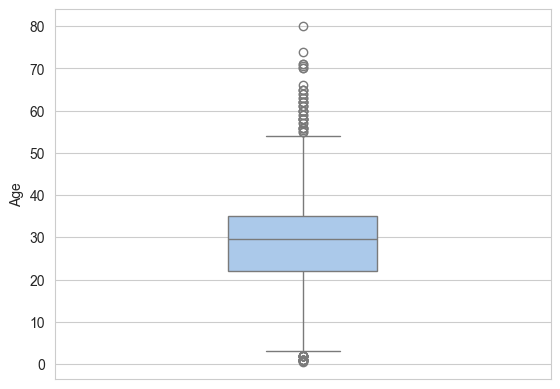

In [161]:
sns.boxplot(y='Age', data=df, width=0.3)
plt.show()

Per quanto riguarda l'età, si notano diversi outlier; tuttavia, si tratta di valori ampiamente leciti come età di una persona, per cui non dobbiamo preoccuparci di gestirli per adesso.

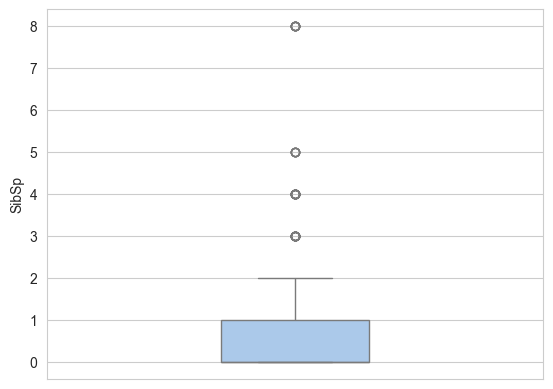

In [162]:
sns.boxplot(y='SibSp', data=df, width=0.3)
plt.show()

Alcuni outlier di questa feature arrivano fino ad 8; questa variabile indica il numero di fratelli/sorelle/sposi a bordo. Considerando l'epoca, non è da escludersi che vi siano persone con questo numero di parentele di primo grado.

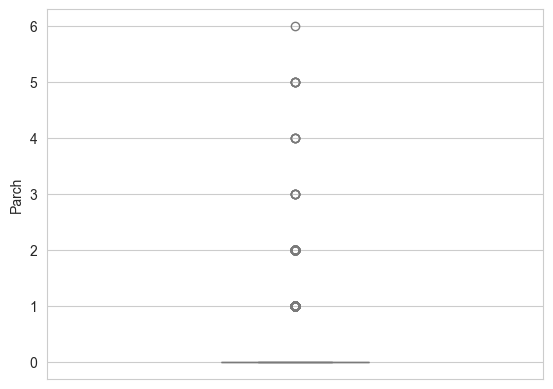

In [163]:
sns.boxplot(y='Parch', data=df, width=0.3)
plt.show()

Da qui notiamo che la maggior parte dei passeggeri hanno viaggiato senza genitori o figli (da notare che alcuni bambini viaggiavano con la tata, per cui questo valore corrisponde a 0 per loro). Data questa predominanza, le persone con genitori o più figli a bordo risultano negli outlier, ma non sembrano numeri impossibili.

Osserviamo gli istrogrammi delle altre feature:

<Axes: xlabel='Pclass'>

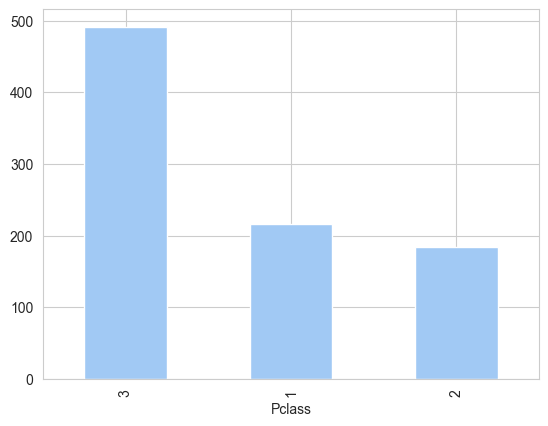

In [164]:
df['Pclass'].value_counts().plot(kind='bar')

Possiamo notare come la maggior parte dei passeggeri abbia viaggiato in terza classe, mentre prima e seconda classe hanno una popolazione simile.

<Axes: xlabel='Sex'>

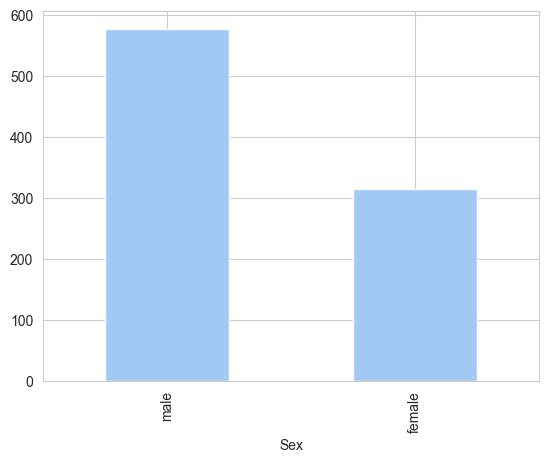

In [165]:
df['Sex'].value_counts().plot(kind='bar')

Notiamo come il rapporto tra passeggeri di sesso maschile e femminile sia di circa 2 a 1.

La feature Survived è stata già osservata precedentemente. Vediamo anche gli istogrammi delle feature relative alla parentela, per comprendere meglio il loro andamento rispetto ai box plot riportati sopra.

<Axes: xlabel='SibSp'>

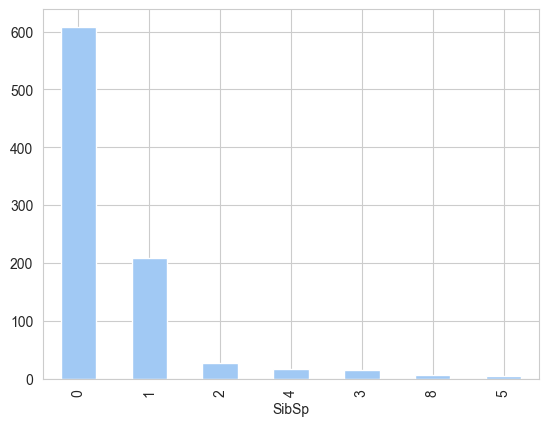

In [166]:
df['SibSp'].value_counts().plot(kind='bar')

<Axes: xlabel='Parch'>

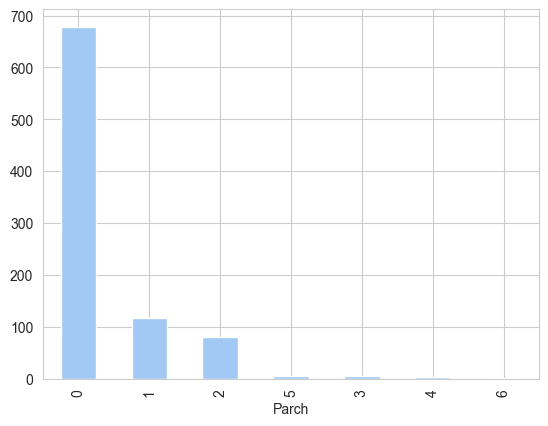

In [167]:
df['Parch'].value_counts().plot(kind='bar')

### 2.2.3 Trasformazione

Non ci sono delle feature per cui occorra cambiare l'unità di misura. Tuttavia, abbiamo una feature categorica da convertire. Questa è di tipo binario e con un ordinamento non richiesto, per cui possaimo procedere con il metodo get_dummies(). Inoltre, sarà sufficiente mantenere solo una delle due colonne: se un passeggero non è maschile, allora è femminile! 

In [168]:
df = df.join(pd.get_dummies(df['Sex']))
df

Pclass     Sex        Age  SibSp  Parch  Survived  female   male
0         3    male  22.000000      1      0         0   False   True
1         1  female  38.000000      1      0         1    True  False
2         3  female  26.000000      0      0         1    True  False
3         1  female  35.000000      1      0         1    True  False
4         3    male  35.000000      0      0         0   False   True
..      ...     ...        ...    ...    ...       ...     ...    ...
886       2    male  27.000000      0      0         0   False   True
887       1  female  19.000000      0      0         1    True  False
888       3  female  29.699118      1      2         0    True  False
889       1    male  26.000000      0      0         1   False   True
890       3    male  32.000000      0      0         0   False   True

[891 rows x 8 columns]

In [169]:
df.drop(['Sex', 'male'], axis=1, inplace=True)
survived_col = df.pop("Survived")
df['Survived'] = survived_col
df

Pclass        Age  SibSp  Parch  female  Survived
0         3  22.000000      1      0   False         0
1         1  38.000000      1      0    True         1
2         3  26.000000      0      0    True         1
3         1  35.000000      1      0    True         1
4         3  35.000000      0      0   False         0
..      ...        ...    ...    ...     ...       ...
886       2  27.000000      0      0   False         0
887       1  19.000000      0      0    True         1
888       3  29.699118      1      2    True         0
889       1  26.000000      0      0   False         1
890       3  32.000000      0      0   False         0

[891 rows x 6 columns]

Può essere utile osservare la matrice di correlazione e calcolare i P-value per capire quali feature possono essere più utili:

In [170]:
from scipy import stats

for col in df.columns:
    pearson_coef, p_value = stats.pearsonr(df[col], df['Survived'])
    print(f"[{col}]: corr = {pearson_coef} | p = {p_value}")

[Pclass]: corr = -0.3384810359610174 | p = 2.537047387979352e-25
[Age]: corr = -0.06980851528714344 | p = 0.03721708372684898
[SibSp]: corr = -0.03532249888573565 | p = 0.2922439286982909
[Parch]: corr = 0.08162940708348367 | p = 0.01479924537472766
[female]: corr = 0.5433513806577602 | p = 1.4060661308752102e-69
[Survived]: corr = 1.0 | p = 0.0


Non notiamo dei valori di correlazione significativi...l'unico parzialmente rilevante è female, con un P-value molto basso, seguito con una debole correlazione da Pclass, anch'essa con un P-value basso. Le altre feature sono scarsamente correlate e con una rilevanza statistica della correlazione un po' limitata.

## 2.3 Train/test split

Applichiamo uno split con metodo holdout:

In [171]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

## 2.4 Feature scaling

Per il feature scaling, ricorriamo allo StandardScaler(). Bisogna però prestare attenzione ad un aspetto: female è una feature con valore 1 o 0 e non va scalata! Si trova nella penultima posizione del dataset, o meglio l'ultima dell'array X. Questa feature la escludiamo dallo StandardScaler:

In [172]:
sc = StandardScaler()
X_train[:, :-1] = sc.fit_transform(X_train[:, :-1])
X_test[:, :-1] = sc.transform(X_test[:, :-1])

## 2.5 Allenamento e predizioni

Eseguiamo un ciclo per ottimizzare il numero di vicini $k$:

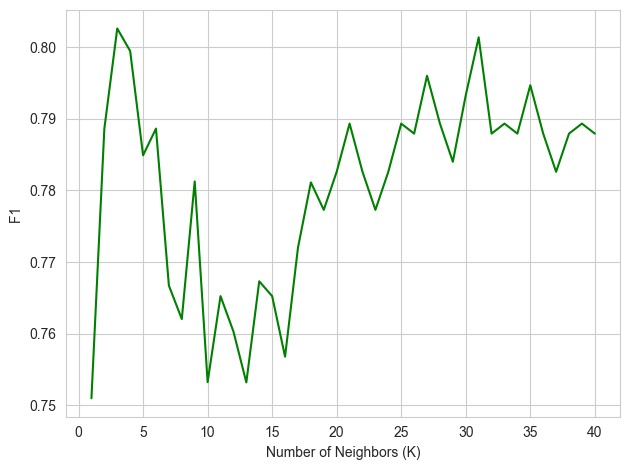

In [173]:
Ks = 41 # massimo valore di k
f1 = np.zeros((Ks-1)) # inizializzazione

for n in range(1,Ks): # iterazione per ogni k

    # Train Model and Predict
    classifier = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_hat = classifier.predict(X_test)
    f1[n-1] = f1_score(y_test, y_hat, average='macro')

# plot
plt.plot(range(1,Ks),f1,'g')
plt.ylabel('F1 ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

Nonostante le correlazioni piuttosto limitate, possiamo notare come il classificatore sia davvero potente nello sfruttare dei legami tra più feature di cui noi non siamo del tutto consapevoli! Il risultato migliore lo otteniamo con $2$.

Possiamo ovviamente anche pensare di ottimizzare gli **iper-parametri** del classificatore: da ora in avanti, per le ottimizzazioni, ricorriamo alla **grid search** che viene implementata tramite la classe [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) del modulo sklearn.model_selection. Da notare che:
- quando creiamo l'istanza di GridSearch, definiamo tutti i range degli iper-parametri su cui vogliamo effettuare la ricerca (si utilizza un dizionario);
- viene effettuato il fit su **tutte le possibili combinazioni di iper-parametri**;
- come risultato, si seleziona il modello che fornisce l'accuratezza migliore.

In [174]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors' : range(1,41),
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=5, scoring='f1_micro', n_jobs=-1, return_train_score=True, verbose=3, error_score=0.0)
grid.fit(X, y)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, error_score=0.0, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1_micro', verbose=3)

Con la macro-average, l'F1 viene calcolato indipendentemente per ogni classe e poi si prende la media artimetica. Con la micro-average, aggrega il contributo di tutte le classi per calcolare la media. Solitamente, quando si hanno problemi multi-classe, la micro-average è l'opzione migliore.

In [175]:
print(grid.best_params_)

{'metric': 'minkowski', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


In [176]:
knn = KNeighborsClassifier(metric='minkowski', n_neighbors=11, p=1, weights='distance').fit(X_train,y_train)

In [177]:
y_hat = knn.predict(X_test)
f1 = f1_score(y_test, y_hat, average='micro')
f1

0.8100558659217877

In [178]:
print(grid.best_score_)

0.8136965664427844


Non ci deve allarmare l'aver ottenuto due risultati diversi qui: l'ottimizzazione degli iper-parametri avviene con k-fold cross-validation, mentre il risultato calcolato sul test set è legato alla divisione fatta con metodo holdout. Da questi due dati, osserviamo che il metodo holdout ci aveva portato ad uno split con una prestazione leggermente polarizzata in modo negativo. 

Osserviamo la confusion matrix per completezza, anche se relativa al metodo holdout:

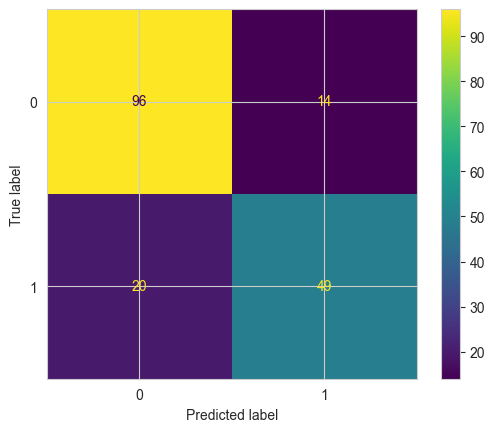

In [179]:
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Una volta individuato il modello migliore, si può addestrare su tutto il dataset a disposizione per poter fare predizioni su dati sconosciuti:

In [180]:
# scaling su tutto il dataset
sc = StandardScaler()
X[:, :-1] = sc.fit_transform(X[:, :-1])

# allenamento su tutto il dataset
knn = KNeighborsClassifier(metric='minkowski', n_neighbors=11, p=1, weights='distance').fit(X,y)

# predizioni: lista con Pclass, Age, SibSp, Parch, female
passenger = pd.DataFrame([[2, 35.6, 3, 1, True]]).to_numpy()
passenger[:, :-1] = sc.transform(passenger[:, :-1])

print(knn.predict(passenger))

[1]


Le prestazioni ottenute sono già significative, con un F1 score pari a circa 0.81. Vediamo però se altri algoritmi di classificazione ci permettono di migliorare...